<a href="https://colab.research.google.com/github/Chovy-Culver/weatherwise-Chufengsheng-Zheng-doe/blob/main/WeatherWise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
# Create a config.py file with the API key
with open("config.py", "w") as f:
    f.write('API_KEY = "1da7dea923d784a5dd83bac94cde8d65"')


In [76]:
from config import API_KEY

print("Your API Key is:", API_KEY)

Your API Key is: 1da7dea923d784a5dd83bac94cde8d65


In [77]:
!mkdir -p weather_data  # create catalog

fetch_code = """
\"""fetch.py - Module for retrieving weather data from OpenWeatherMap API.\"""

import requests
from config import API_KEY

BASE_URL = "https://api.openweathermap.org/data/2.5/"

def fetch_current_weather(city):
    \"\"\"Fetch current weather data for a given city.\"\"\"
    url = f"{BASE_URL}weather?q={city}&appid={API_KEY}&units=metric"
    response = requests.get(url)
    return response.json() if response.status_code == 200 else None

def fetch_forecast_weather(city):
    \"\"\"Fetch 5-day forecast data (3-hour intervals) for a given city.\"\"\"
    url = f"{BASE_URL}forecast?q={city}&appid={API_KEY}&units=metric"
    response = requests.get(url)
    return response.json() if response.status_code == 200 else None
"""

with open("weather_data/fetch.py", "w") as f:
    f.write(fetch_code)


In [78]:
import sys
sys.path.append('/content')


In [79]:
from weather_data.fetch import fetch_current_weather

city = "Perth"
data = fetch_current_weather(city)

print(data if data else "❌ Failed to fetch weather.")


{'coord': {'lon': 115.8333, 'lat': -31.9333}, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01n'}], 'base': 'stations', 'main': {'temp': 18.06, 'feels_like': 17.78, 'temp_min': 17.69, 'temp_max': 18.35, 'pressure': 1023, 'humidity': 71, 'sea_level': 1023, 'grnd_level': 1021}, 'visibility': 10000, 'wind': {'speed': 7.72, 'deg': 170}, 'clouds': {'all': 0}, 'dt': 1747649221, 'sys': {'type': 2, 'id': 63154, 'country': 'AU', 'sunrise': 1747609241, 'sunset': 1747646750}, 'timezone': 28800, 'id': 2063523, 'name': 'Perth', 'cod': 200}


In [80]:
# create file
!mkdir -p weather_data

# import visualise.py
visualise_code = """
\"\"\"visualise.py - Module for visualising weather forecast data.\"\"\"

import matplotlib.pyplot as plt
from datetime import datetime

def plot_temperature_trend(forecast_data, city):
    times = []
    temps = []
    for entry in forecast_data['list']:
        dt = datetime.strptime(entry['dt_txt'], "%Y-%m-%d %H:%M:%S")
        temp = entry['main']['temp']
        times.append(dt)
        temps.append(temp)
    plt.figure(figsize=(10, 5))
    plt.plot(times, temps, marker='o')
    plt.title(f"Temperature Trend in {city}")
    plt.xlabel("Date & Time")
    plt.ylabel("Temperature (°C)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

def plot_precipitation_probability(forecast_data, city):
    times = []
    probs = []
    for entry in forecast_data['list']:
        dt = datetime.strptime(entry['dt_txt'], "%Y-%m-%d %H:%M:%S")
        prob = entry.get('pop', 0) * 100
        times.append(dt)
        probs.append(prob)
    plt.figure(figsize=(10, 5))
    plt.bar(times, probs)
    plt.title(f"Precipitation Probability in {city}")
    plt.xlabel("Date & Time")
    plt.ylabel("Probability (%)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

def plot_wind_speed(forecast_data, city):
    times = []
    speeds = []
    for entry in forecast_data['list']:
        dt = datetime.strptime(entry['dt_txt'], "%Y-%m-%d %H:%M:%S")
        speed = entry['wind']['speed']
        times.append(dt)
        speeds.append(speed)
    plt.figure(figsize=(10, 5))
    plt.plot(times, speeds, marker='s', linestyle='--')
    plt.title(f"Wind Speed Forecast in {city}")
    plt.xlabel("Date & Time")
    plt.ylabel("Wind Speed (m/s)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()
"""

with open("weather_data/visualise.py", "w") as f:
    f.write(visualise_code)


In [81]:
import sys
sys.path.append('/content')


In [82]:
from weather_data.visualise import (
    plot_temperature_trend,
    plot_precipitation_probability,
    plot_wind_speed
)
print("✅ visualise module imported successfully.")


✅ visualise module imported successfully.


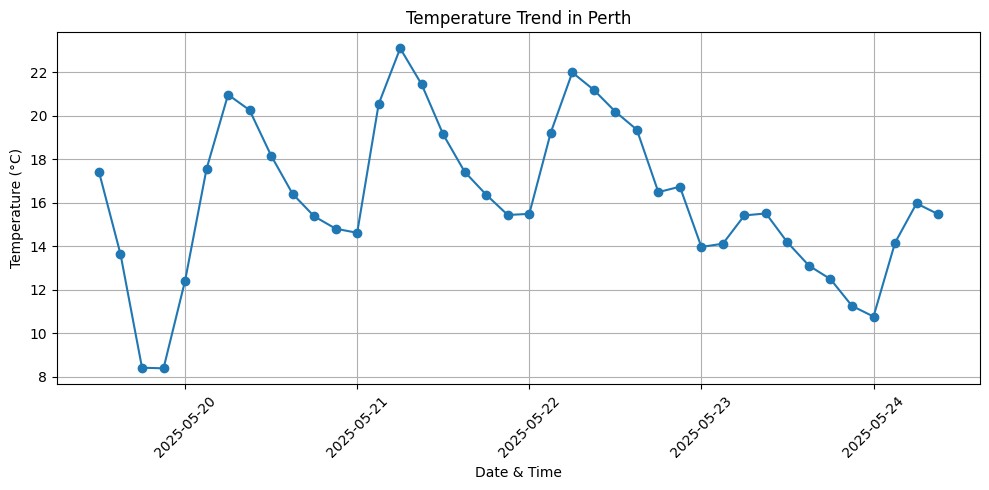

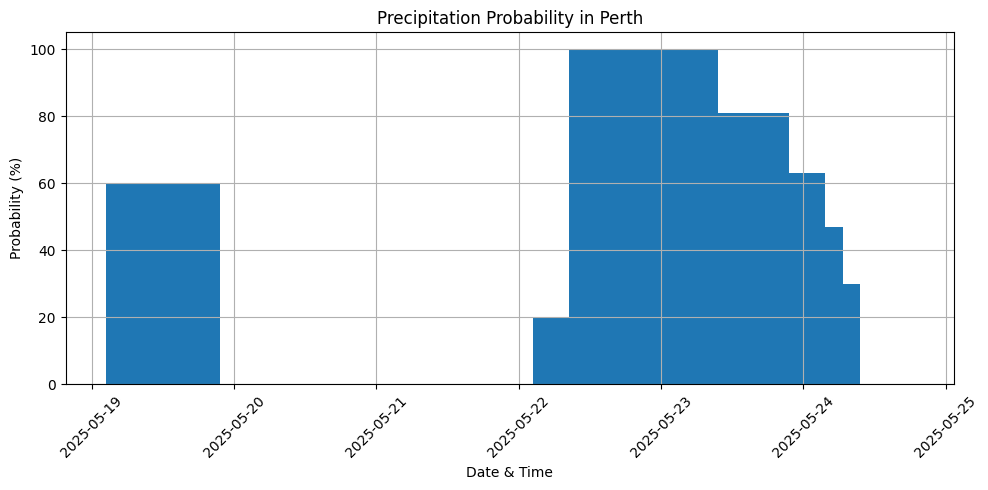

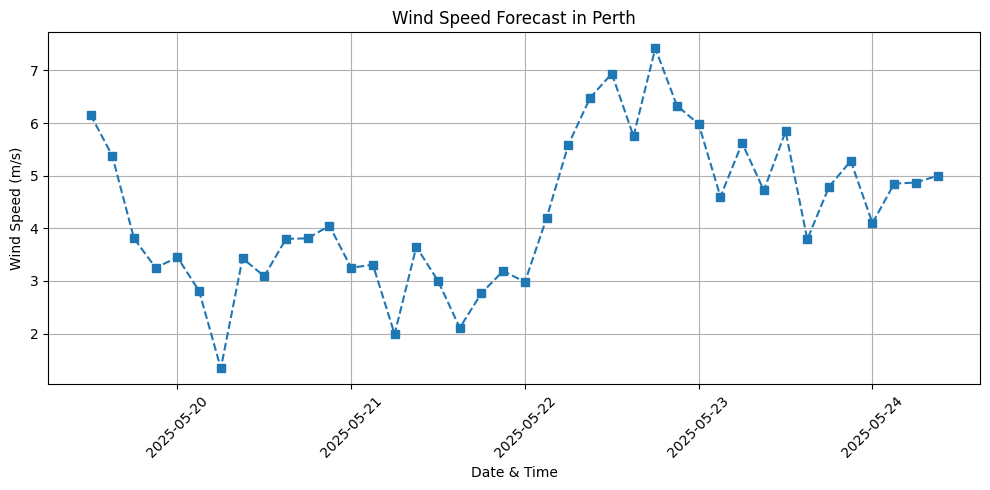

In [83]:
from weather_data.fetch import fetch_forecast_weather
from weather_data.visualise import (
    plot_temperature_trend,
    plot_precipitation_probability,
    plot_wind_speed
)

city = "Perth"
forecast = fetch_forecast_weather(city)

if forecast:
    plot_temperature_trend(forecast, city)
    plot_precipitation_probability(forecast, city)
    plot_wind_speed(forecast, city)
else:
    print("❌ Failed to fetch forecast data.")


In [84]:
"""
parser.py - Smart parser for weather intent and time keyword detection.
"""

from difflib import get_close_matches
import re

INTENT_KEYWORDS = {
    "temperature": ["cold", "hot", "temperature", "jacket", "coat", "sweater", "warm", "cool", "wear"],
    "rain": ["rain", "umbrella", "wet", "drizzle"],
    "wind": ["wind", "windy", "breeze", "gust"]
}

TIME_KEYWORDS = {
    "today": ["today", "now", "currently"],
    "tomorrow": ["tomorrow", "next day"],
    "day after tomorrow": ["day after tomorrow"]
}

# Map keywords to intent or time
KEYWORD_TO_INTENT = {k: intent for intent, lst in INTENT_KEYWORDS.items() for k in lst}
KEYWORD_TO_TIME = {k: time for time, lst in TIME_KEYWORDS.items() for k in lst}

def infer_weather_intent(user_input):
    words = re.findall(r'\w+', user_input.lower())
    for word in words:
        if word in KEYWORD_TO_INTENT:
            return KEYWORD_TO_INTENT[word]
        match = get_close_matches(word, KEYWORD_TO_INTENT.keys(), n=1, cutoff=0.8)
        if match:
            return KEYWORD_TO_INTENT[match[0]]
    return None

def infer_time_keyword(user_input):
    words = re.findall(r'\w+', user_input.lower())
    for word in words:
        if word in KEYWORD_TO_TIME:
            return KEYWORD_TO_TIME[word]
        match = get_close_matches(word, KEYWORD_TO_TIME.keys(), n=1, cutoff=0.8)
        if match:
            return KEYWORD_TO_TIME[match[0]]
    return None


In [85]:
import os
os.makedirs("/content/nlp_interface", exist_ok=True)

parser_code = '''"""
parser.py - Enhanced parser with fuzzy matching for weather intent detection.
"""

from difflib import get_close_matches

INTENT_KEYWORDS = {
    "temperature": ["cold", "hot", "temperature", "jacket", "warm", "cool"],
    "rain": ["rain", "umbrella", "wet", "drizzle"],
    "wind": ["wind", "windy", "breeze", "gust"]
}

# Flatten all keywords to map them to intents
KEYWORD_TO_INTENT = {
    keyword: intent
    for intent, keywords in INTENT_KEYWORDS.items()
    for keyword in keywords
}

def infer_weather_intent(user_input):
    \"\"\"
    Infer weather intent from input using exact and fuzzy keyword matching.
    Returns one of: "temperature", "rain", "wind", or None.
    \"\"\"
    user_input = user_input.lower().split()

    for word in user_input:
        # Exact match
        if word in KEYWORD_TO_INTENT:
            return KEYWORD_TO_INTENT[word]
        # Fuzzy match
        match = get_close_matches(word, KEYWORD_TO_INTENT.keys(), n=1, cutoff=0.8)
        if match:
            return KEYWORD_TO_INTENT[match[0]]

    return None
'''

with open("/content/nlp_interface/parser.py", "w") as f:
    f.write(parser_code)


In [86]:
responder_code = '''"""
responder.py - Generate smart weather responses based on intent.
"""

def handle_temperature(weather_data):
    temp = weather_data['main']['temp']
    desc = weather_data['weather'][0]['description']

    if temp < 5:
        return f"It’s very cold ({temp}°C, {desc}). You should wear a coat or thick sweater."
    elif temp < 12:
        return f"It’s chilly ({temp}°C, {desc}). A warm jacket is a good idea."
    elif temp < 20:
        return f"The weather is mild ({temp}°C, {desc}). You might want a light jacket."
    else:
        return f"It’s warm today ({temp}°C, {desc}). Light clothing should be fine."

def handle_rain(weather_data):
    desc = weather_data['weather'][0]['description'].lower()
    if "rain" in desc or "drizzle" in desc:
        return f"It looks like rain ({desc}). Don’t forget your umbrella!"
    else:
        return f"No rain expected today. Conditions are {desc}."

def handle_wind(weather_data):
    speed = weather_data['wind']['speed']
    if speed > 10:
        return f"It’s quite windy today with wind speeds around {speed} m/s."
    else:
        return f"Wind is mild today at around {speed} m/s."

INTENT_HANDLERS = {
    "temperature": handle_temperature,
    "rain": handle_rain,
    "wind": handle_wind
}

def generate_response(intent, weather_data):
    if not weather_data:
        return "Sorry, I couldn't get the weather data right now."

    handler = INTENT_HANDLERS.get(intent)
    if handler:
        return handler(weather_data)
    else:
        return "I'm not sure what weather info you need. Try asking about temperature, rain, or wind."
'''

with open("/content/nlp_interface/responder.py", "w") as f:
    f.write(responder_code)


In [87]:
responder_code = '''"""
responder.py - Modular response generator with intent-function mapping.
"""

def handle_temperature(weather_data):
    temp = weather_data['main']['temp']
    desc = weather_data['weather'][0]['description']

    if temp < 10:
        return f"It's quite cold with {temp}°C and {desc}. You might need a coat."
    elif temp < 20:
        return f"The temperature is {temp}°C with {desc}. Maybe bring a light jacket."
    else:
        return f"It's warm today at {temp}°C with {desc}."

def handle_rain(weather_data):
    desc = weather_data['weather'][0]['description'].lower()
    if "rain" in desc or "drizzle" in desc:
        return f"Yes, it looks like rain today: {desc}. Don't forget your umbrella!"
    else:
        return f"No rain expected today. Conditions are {desc}."

def handle_wind(weather_data):
    speed = weather_data['wind']['speed']
    if speed > 10:
        return f"It’s quite windy today with wind speeds around {speed} m/s."
    else:
        return f"Wind is mild today at around {speed} m/s."

# Intent to handler function mapping
INTENT_HANDLERS = {
    "temperature": handle_temperature,
    "rain": handle_rain,
    "wind": handle_wind
}

def generate_response(intent, weather_data):
    \"\"\"
    Generate a natural language weather response based on user intent.
    \"\"\"
    if not weather_data:
        return "Sorry, I couldn't get the weather data right now."

    handler = INTENT_HANDLERS.get(intent)
    if handler:
        return handler(weather_data)
    else:
        return "I'm not sure what weather info you need. Please ask about temperature, rain, or wind."
'''

with open("/content/nlp_interface/responder.py", "w") as f:
    f.write(responder_code)


In [88]:
pip install pyinputplus


In [90]:
import os

# Make sure the ui/ directory exists
os.makedirs("/content/ui", exist_ok=True)

# Now write the clean English version of menu.py
menu_code = '''"""
menu.py - Interactive weather application menu using pyinputplus.
"""

import pyinputplus as pyip
from weather_data.fetch import fetch_current_weather, fetch_forecast_weather
from weather_data.visualise import (
    plot_temperature_trend,
    plot_precipitation_probability,
    plot_wind_speed
)
from nlp_interface.parser import infer_weather_intent
from nlp_interface.responder import generate_response
from ui.display import show_weather_info, show_error

def handle_check_weather():
    city = pyip.inputStr("Enter a city name: ")
    data = fetch_current_weather(city)
    if data:
        show_weather_info(data)
    else:
        show_error("Could not retrieve current weather data.")

def handle_show_charts():
    city = pyip.inputStr("Enter a city name: ")
    forecast = fetch_forecast_weather(city)
    if not forecast:
        show_error("Could not retrieve forecast data.")
        return

    chart_actions = {
        "Temperature Trend": plot_temperature_trend,
        "Precipitation Probability": plot_precipitation_probability,
        "Wind Speed": plot_wind_speed
    }

    chart_choice = pyip.inputMenu(list(chart_actions.keys()), numbered=True)
    chart_actions[chart_choice](forecast, city)

def handle_ask_question():
    city = pyip.inputStr("Enter a city name: ")
    question = pyip.inputStr("Ask your weather-related question (e.g., 'Will it rain tomorrow?'): ")
    intent = infer_weather_intent(question)
    weather = fetch_current_weather(city)
    response = generate_response(intent, weather)
    print("\\n🤖", response)

def handle_exit():
    print("Thank you for using WeatherWise. Goodbye!")
    exit()

MENU_ACTIONS = {
    "Check Current Weather": handle_check_weather,
    "Show Forecast Charts": handle_show_charts,
    "Ask a Weather Question": handle_ask_question,
    "Exit": handle_exit
}

def weather_menu():
    while True:
        print("\\n=== WeatherWise Main Menu ===")
        choice = pyip.inputMenu(list(MENU_ACTIONS.keys()), numbered=True)
        action = MENU_ACTIONS.get(choice)
        if action:
            action()
'''

with open("/content/ui/menu.py", "w") as f:
    f.write(menu_code)

print("✅ Rewritten ui/menu.py successfully saved to /content/ui/")


✅ Rewritten ui/menu.py successfully saved to /content/ui/


In [91]:
os.makedirs("/content/ui", exist_ok=True)

display_code = '''"""
display.py - Simple display helpers for WeatherWise.
"""

def show_weather_info(data):
    print(f"🌤️ Weather in {data['name']}: {data['main']['temp']}°C, {data['weather'][0]['description']}")

def show_error(message):
    print(f"❌ {message}")
'''

with open("/content/ui/display.py", "w") as f:
    f.write(display_code)


In [92]:
import sys
sys.path.append('/content')


In [93]:
import os
os.makedirs("/content/ui", exist_ok=True)

smart_code = """<PASTE FULL FUNCTION CODE ABOVE HERE>"""  # Replace with full code

with open("/content/ui/smart_conversation.py", "w") as f:
    f.write(smart_code)

print("✅ smart_conversation.py has been saved.")


✅ smart_conversation.py has been saved.


In [94]:
parser_fixed_code = """<PASTE FULL UPDATED CODE ABOVE HERE>"""

with open("/content/nlp_interface/parser.py", "w") as f:
    f.write(parser_fixed_code)

print("✅ Fixed parser.py saved with infer_time_keyword.")


✅ Fixed parser.py saved with infer_time_keyword.


In [112]:
import os

os.makedirs("/content/ui", exist_ok=True)

menu_code = '''"""
menu.py - Interactive weather application menu using pyinputplus.
"""

import pyinputplus as pyip
from weather_data.fetch import fetch_current_weather, fetch_forecast_weather
from weather_data.visualise import (
    plot_temperature_trend,
    plot_precipitation_probability,
    plot_wind_speed
)
from nlp_interface.parser import infer_weather_intent
from nlp_interface.responder import generate_response
from ui.display import show_weather_info, show_error

def handle_check_weather():
    city = pyip.inputStr("Enter a city name: ")
    data = fetch_current_weather(city)
    if data:
        show_weather_info(data)
    else:
        show_error("Could not retrieve current weather data.")

def handle_show_charts():
    city = pyip.inputStr("Enter a city name: ")
    forecast = fetch_forecast_weather(city)
    if not forecast:
        show_error("Could not retrieve forecast data.")
        return

    chart_actions = {
        "Temperature Trend": plot_temperature_trend,
        "Precipitation Probability": plot_precipitation_probability,
        "Wind Speed": plot_wind_speed
    }

    chart_choice = pyip.inputMenu(list(chart_actions.keys()), numbered=True)
    chart_actions[chart_choice](forecast, city)

def handle_ask_question():
    city = pyip.inputStr("Enter a city name: ")
    question = pyip.inputStr("Ask your weather-related question (e.g., 'Will it rain tomorrow?'): ")
    intent = infer_weather_intent(question)
    weather = fetch_current_weather(city)
    response = generate_response(intent, weather)
    print("\\n🤖", response)

def handle_exit():
    print("Thank you for using WeatherWise. Goodbye!")
    exit()

MENU_ACTIONS = {
    "Check Current Weather": handle_check_weather,
    "Show Forecast Charts": handle_show_charts,
    "Ask a Weather Question": handle_ask_question,
    "Exit": handle_exit
}

def weather_menu():
    while True:
        print("\\n=== WeatherWise Main Menu ===")
        choice = pyip.inputMenu(list(MENU_ACTIONS.keys()), numbered=True)
        action = MENU_ACTIONS.get(choice)
        if action:
            action()
'''

with open("/content/ui/menu.py", "w") as f:
    f.write(menu_code)

print("✅ menu.py successfully rewritten to /content/ui/")


✅ menu.py successfully rewritten to /content/ui/


In [ ]:
from ui.menu import weather_menu
weather_menu()



=== WeatherWise Main Menu ===
Please select one of the following:
1. Check Current Weather
2. Show Forecast Charts
3. Ask a Weather Question
4. Exit
3
Enter a city name: perth
Ask your weather-related question (e.g., 'Will it rain tomorrow?'): do i need to bring an umbrella tomorrow

🤖 No rain expected today. Conditions are clear sky.

=== WeatherWise Main Menu ===
Please select one of the following:
1. Check Current Weather
2. Show Forecast Charts
3. Ask a Weather Question
4. Exit
